In [1]:
import pandas as pd
import numpy as np
import math
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,8)

## Grid Search, Hyperparamaters, and Cross Validation

A large part of setting up machine learning models involves repetitive trials, and trial and error tests. We have several tools that can largely automate this trial process, saving us the trouble of making repetitve loops and managing large lists of test values and results. 

One of the things that we can use this for is to find good values for what we call Hyperparamaters - or the values that steer the model creation process. 

In [2]:
def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
    df['target'] = pd.Series(sklearn_dataset.target)
    return df

df = sklearn_to_df(sklearn.datasets.load_breast_cancer())
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


<h4>Generate Decision Tree Model</h4>

7
0.9440559440559441


[Text(306.9, 407.7, 'X[27] <= 0.145\ngini = 0.47\nsamples = 426\nvalue = [161, 265]'),
 Text(228.97241379310344, 353.34000000000003, 'X[23] <= 929.8\ngini = 0.161\nsamples = 283\nvalue = [25, 258]'),
 Text(165.4758620689655, 298.98, 'X[22] <= 107.05\ngini = 0.079\nsamples = 266\nvalue = [11, 255]'),
 Text(100.0551724137931, 244.62, 'X[27] <= 0.135\ngini = 0.033\nsamples = 242\nvalue = [4, 238]'),
 Text(61.57241379310344, 190.26, 'X[13] <= 48.975\ngini = 0.017\nsamples = 236\nvalue = [2, 234]'),
 Text(30.78620689655172, 135.89999999999998, 'X[21] <= 33.35\ngini = 0.009\nsamples = 234\nvalue = [1, 233]'),
 Text(15.39310344827586, 81.54000000000002, 'gini = 0.0\nsamples = 219\nvalue = [0, 219]'),
 Text(46.179310344827584, 81.54000000000002, 'X[21] <= 33.56\ngini = 0.124\nsamples = 15\nvalue = [1, 14]'),
 Text(30.78620689655172, 27.180000000000007, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(61.57241379310344, 27.180000000000007, 'gini = 0.0\nsamples = 14\nvalue = [0, 14]'),
 Text(92

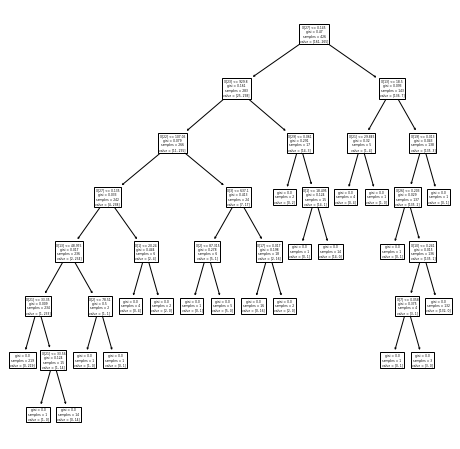

In [3]:
df2 = pd.get_dummies(df, drop_first=True)
y = np.array(df2["target"]).reshape(-1,1)
X = np.array(df2.drop(columns={"target"}))

X_train, X_test, y_train, y_test = train_test_split(X, y)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
print(clf.get_depth())
print(clf.score(X_test, y_test))
plot_tree(clf)

### What if we want to limit max depth, or similar?

Now, if we wanted to run a trial with different max depths we could just change the number in the argument and repeat. If we wanted to get a little more sophisticated, we could write a loop to try a few and see the results. However, what if we want to change several of these hyperparamaters in different trials? Writting a nested loop for each different value we're changing could become pretty cumbersome, and the more clunky it is, the more likely we are to make a mistake. 

### Hyperparamaters and GridSearchCV

Luckily, this is a common task, so there are prebuilt ways to do it efficiently. What we are doing here is Hyperparamater Tuning, and the tool we'll use is called GridSearchCV, from sklearn. GridSearchCV is effectively a shortcut to nested loops for each hyperparamater - we provide a list of which variables we'd like to change, and which values we'd like the system to try, and it does the messy work of running a bunch of trials behind the scenes for us. Much easier to use, and less prone to making a mistake. 

For this trial, we'll change the max depth and also the min_samples_split value - this hyperparamater sets how many values must be in one node before it can be split into 2. The default is 2, and this may sometimes lead to overfitting - we can try a few other options. 

In [4]:
from sklearn.model_selection import GridSearchCV

#Create a dictionary of HP names and lists of potential values. 
#The grid search will try all of these options. 
tree_para = {'min_samples_split':[2,3,4,5,6,7],'max_depth':[3,4,5,6,7,8]}

clf = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=tree_para, cv=10) #See below for the CV argument
clf.fit(X_train, y_train)
clf.best_estimator_

DecisionTreeClassifier(max_depth=8, min_samples_split=3)

Voila!!

There is not much of a downside to trying every possible combination of every HP, especially for us with our small datasets. The main drawback is that this can become REALLY computationally expensive with lots of options and large amounts of data. The growth in calculation time grows exponentially the more options are added, so for real world datasets just "trying everything" is probably prohibitably slow. 

There are some ways to cut down on useless trials, some are listed in the sklearn documentation. We'll look at making this better more in the future in a little more depth. For large datasets, taking a sample to experiment on is probably a prudent move. 

## Cross Validation

The CV argument above stands for cross validation - another way to prevent overfitting and increase overall accuracy. Cross validation is basically a supercharged test-train split. 

The standard test-train split divides the data 70/30ish, and calculating the accuracy using that reserved 30ish percent. 

Cross validation makes K splits in the data, and repeats this test-train calculation K times. Each time a different subset is the test set, and the rest of the data is the training set. The overall score is the average of all those K trials. There are other methods in addition to K-fold, such as Leave-One-Out, which leaves only 1 example in the test set, and others that stratify to deal with target imbalance. Using these is pretty similar, we'll touch on them later. 

Cross validation is a very common step in machine learning. It reduces variance in the results as any random difference in the test-train split is negated by all the other samples. In general, cross validation will give more reliable results due to that reduction in variance - that effect being greater when there are outliers (think if one outlier is tested in a linear regression, that amount of error may be substantial).

We will use a separate cross validation in the future, it is also in sklearn and is pretty straightforward. We commonly use it as part of the grid search as we have here, since both are common this makes it easier and more compact. There are also a few more options that we'll tweak later on, but they are pretty simple. 

<h3>Why is There Still a Test Set?</h3>

The image (from sklearn), and the code below, employ both the test-train split and the cross validation. This is the technically correct way to do it. We want to test on data that the model has never encountered in its training. In this setup, the test set is the same as it always way, and the cross validation creates a bunch of validation splits that help train the data. In practice, if you didn't do this it would rarely have a big impact on the outcome. Examples across the internet will show it both ways, don't worry about it too much, it is a more academic concern. 

This does bring up one point that matters when looking to actually use one of these models. All of the work we've done so far has been on building and evaluating a predicitve model. When that's finished, we'd probably want to use it in production. When this happens we normally want to use all of our data (no test-train split) to create the final model. The idea is that we've already determined that the given algorithm and hyperparamaters are good in creating a model, now we want to create a version without that test data withheld so we can benefit from all the data in making the final model. We won't have a real test score for this model, as there is no leftover data to test it on, but we can pretty safely assume that it'll be at least as good as the one we built with a split. 

![Cross Validation](images/grid_search_cross_validation.png "Cross Validation" )

### Cross Validation Scoring

We can use cross validation scoring on its own in place of normal scoring very easily to get a cross-validated version of the training scores, just replace the score function with cross_val_score. The result becomes an array of all the scores. 

A K value of 5 to 10 is pretty typical. 

In [5]:
#Cross validation scoring
crossV = DecisionTreeClassifier()
scores = cross_val_score(crossV, X, y, cv=5)
scores

array([0.9122807 , 0.92982456, 0.92105263, 0.94736842, 0.89380531])

#### Exercise - Make Your Own Grid

Try to make a similar gridsearch with some differnent hyperparamaters. Look on the documentation page in sklearn and try a few options. 

In [6]:
#EXERCISE


## Random Forest - Ensamble

One common improvement made when using trees is to use several of them, or make a forest instead of a tree. More generally, this is our first look at an ensamble model - combining two or more predictive models to make a final prediction. 

The most simple way to create an ensamble is to use a Random Forest, which generates several trees that make predictions in parallel, then those predictions are combined (for a classification, majority wins) to make the final prediction. The magic behind this is that we are creating several uncorrelated predictions - each tree is generated from a random subset of the data. 

Random forests employ an ensamble method called Bagging, meaning that we run a bunch of models parallel to each other and get the result by combining the individual results; i.e. all the models are in a bag, and we pull out their combined answer. Another ensamble method is called boosting - using the results of one model's predictions to improve another's; we will look at boosting later in the course. 

Random forests will generally deliver more accuracy and less overfitting than a singular tree. More specifically it will tend to reduce the varaince in the predictions, as overfitting tends to 'cancel out' (sklearn's words) when many trees are created independently.

Using a Ramdom Forest is pretty easy, we can try one with a grid search, and up the number of HPs that we are tuning. Check the documentation page for a look at the paramaters that we could use: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html 

<b>Note:</b> the n_jobs argument is optional, that tells the system to create that number of threads, and those threads will be run in parallel on different cores of the computer. Modern CPUs have a bunch of cores 4-16 or more, so there's potential for some speedup there. My work Macbook I made this on has 4 (which I think can each double thread, to 8). If you get a weird error, just remove this. This isn't really a need to know, but it may speed some stuff up here and there. If someone were doing this on a powerful server you might have 64 cores, so you'd set that number to be high to ensure that calculations went in parallel on each one. 

In [7]:
rf_para = {'min_samples_split':[3,4,5,6,7],
            'max_depth':[3,4,5,6,7,8],
            'n_estimators':[20,50,80],
            'criterion':["gini","entropy"],
            'max_samples':[.4, .5, .6, .7]}

#clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_para, cv=10)
# If you get some weird error, uncomment above, and comment the line below. See the note above for more. 
 
clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_para, cv=10, n_jobs=4) 
clf.fit(X_train, y_train.ravel())
clf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=7, max_samples=0.7,
                       min_samples_split=4, n_estimators=80)

### Pipeline with GridSearchCV

We can also use this with a pipeline, the main changes are:
<ul>
<li>The estimator in the grid search becomes the pipeline.
<li>The paramaters in the param_grid need to be named "stepName__variable". See the example below.
</ul>

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
estimator = RandomForestClassifier(n_jobs=-1)
pipe = Pipeline(steps=[("scaler", scaler), ("forrest", estimator)])

params = {'forrest__max_depth':[5,6,7,8,9]}
 
clf = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1) 
clf.fit(X_train, y_train.ravel())
best = clf.best_estimator_
print(best.score(X_test, y_test))
print(best)

0.972027972027972
Pipeline(steps=[('scaler', StandardScaler()),
                ('forrest', RandomForestClassifier(max_depth=5, n_jobs=-1))])


## Non-Tree Bagging

In general the BaggingClassifier in sklearn can apply the same concept to other classification methods, and the BaggingRegressor can do the same for regression. 

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(base_estimator=LogisticRegression(max_iter=10000),n_estimators=10, random_state=0).fit(X_train, y_train.ravel())
bag.score(X_test, y_test)

0.9300699300699301

<h2>Working Example</h2>


In [10]:
df_ = sklearn_to_df(sklearn.datasets.load_iris())
df_.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [11]:
#Model
from sklearn.preprocessing import MinMaxScaler

y_ = np.array(df_["target"]).reshape(-1,1)
X_ = np.array(df_.drop(columns={"target"}))
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_)

scaler_ = MinMaxScaler()
estimator_ = RandomForestClassifier(n_jobs=-1)
pipe_ = Pipeline(steps=[("scaler", scaler_), ("forrest", estimator_)])

params_ = {'forrest__max_depth':[5,6,7,8,9], "forrest__n_estimators":[75,100,125]}
 
clf_ = GridSearchCV(pipe_, param_grid=params_, cv=5, n_jobs=-1) 
clf_.fit(X_train_, y_train_.ravel())
best_ = clf_.best_estimator_
print(best_.score(X_test_, y_test_))
print(best_)

0.9736842105263158
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('forrest',
                 RandomForestClassifier(max_depth=5, n_estimators=125,
                                        n_jobs=-1))])
